A recommender system refers to a system that is capable of predicting the future preference of a set of items for a user, and recommend the top items. 

Importing Needed Libraries

In [ ]:
!pip install surprise

In [1]:
# Importing Libraires
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Loading Our datasets

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load Movies datasets
path_to_data = '/content/drive/MyDrive/Recommender_Sys/'

df_credits = pd.read_csv( path_to_data + 'tmdb_5000_credits.csv')
df_movies = pd.read_csv( path_to_data + 'tmdb_5000_movies.csv')

In [4]:
# Print the first rows
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
# Print the first rows
df_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
df_credits.columns = ['id','tittle','cast','crew']
df_movies= df_movies.merge(df_credits,on='id')

## 1 - Demographic Filtering
  - The simplest way to recommend by offering a generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to all users.

Building Simple Recommender System based on the metric below:
- weighted_Rating(WR) = ((v/v+m).R) + ((m/v+m).C)
 * V --> is the number of votes for the movie. (vote_count)
 * M --> is the min votes required to be listed in chart. (based on negative vote)
 * R --> is the average rating of the movie. (vote_average)
 * C --> is the mean vote across the the whole report. (calculate from data)

In [7]:
# let's compute the mean vote (C) across the the whole available data for all movies.
C = df_movies['vote_average'].mean()
C

6.092171559442016

So, on a scale of 1 to 10, the average rating for all the films is approximately 6.

In [8]:
# now let's compute the minimum number of votes for a movie to be considered with us.
# so let's say that a movie must receive more votes than at least 90% of the other movies to be considered.
M = df_movies['vote_count'].quantile(0.9)
M

1838.4000000000015

In [9]:
# Now, we can filter out the movies that will be considered which their votes will be more than m.
considered_movies = df_movies.copy().loc[df_movies['vote_count'] >= M]
considered_movies.shape

(481, 23)

In [10]:
def weighted_rating(df, M=M, C=C):
    V = df['vote_count']
    R = df['vote_average']
    # Calculation based on the IMDB formula
    return (V/(V+M) * R) + (M/(M+V) * C)

In [11]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
considered_movies['score'] = considered_movies.apply(weighted_rating, axis=1)

In [12]:
#Sort movies based on score calculated above
considered_movies = considered_movies.sort_values('score', ascending=False)

#Print the top 15 movies
considered_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

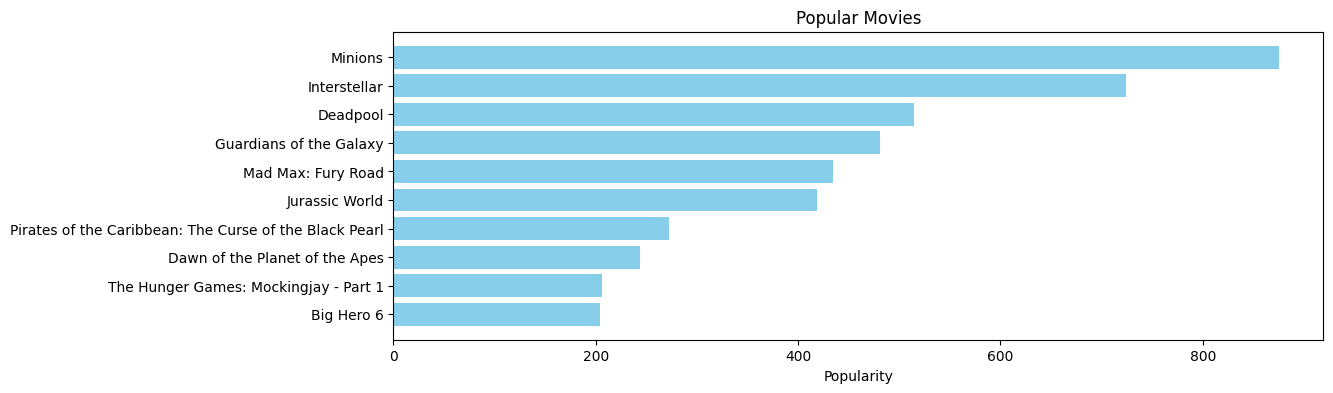

In [13]:
pop= df_movies.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

## 2- Content Based Filtering

In [14]:
df_movies['overview'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [15]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df_movies['overview'] = df_movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_movies['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

Now lets' compute the pair-wise cosine similarity between all overviews of movies. 

Remember: since that:

$$x.y = ||x||.||y||.cos(\theta)$$

So 
$$cos(\theta) = \frac{x.y}{||x||||y||}$$

So we can use the `linear_kernel` from sklearn, which is faster than `cosine_similarity`

In [16]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

In [17]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df_movies.index, index=df_movies['title']).drop_duplicates()

In [18]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, df_movies=df_movies, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_movies['title'].iloc[movie_indices]

In [19]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [20]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

### **Credits, Genres and Keywords Based Recommender**
It goes without saying that using better metadata would improve the quality of our recommender. That is exactly what we will do in this section. We make a recommendation based on the following metadata: top 3  actors,  director, related genres and  movie plot keywords. 
 
 Among the cast, crew and keywords, we have to single out the top three actors, directors and keywords associated with this movie. Right now our data is in "flexible" lists, we need to transform it into a safe and usable structure

In [21]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df_movies[feature] = df_movies[feature].apply(literal_eval)

In [22]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [23]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [24]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df_movies['director'] = df_movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df_movies[feature] = df_movies[feature].apply(get_list)

In [25]:
# Print the new features of the first 3 films
df_movies[['title', 'cast', 'director', 'keywords', 'genres']].head()

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"


In [26]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [27]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df_movies[feature] = df_movies[feature].apply(clean_data)

Now we can create our "metadata soup", which is a string containing all the metadata  we want to insert into the vectorization (ie actors, director and keywords).

In [28]:
# Create a new soup feature
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [29]:
df_movies['soup'] = df_movies.apply(create_soup, axis=1)

In [30]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_movies['soup'])

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_movies['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
# Reset index of your main DataFrame and construct reverse mapping as before
metadata = df_movies.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])

In [32]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [33]:
get_recommendations('The Dark Knight Rises', cosine_sim)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [34]:
get_recommendations('The Godfather', cosine_sim)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

In [35]:
get_recommendations('The Avengers', cosine_sim)

7                  Avengers: Age of Ultron
26              Captain America: Civil War
79                              Iron Man 2
169     Captain America: The First Avenger
174                    The Incredible Hulk
85     Captain America: The Winter Soldier
31                              Iron Man 3
33                   X-Men: The Last Stand
68                                Iron Man
94                 Guardians of the Galaxy
Name: title, dtype: object

## **Collaborative Filtering**
*  **User based filtering**-  These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.

* **Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.

In [37]:
reader = Reader()
ratings = pd.read_csv( path_to_data + 'ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [38]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)

In [39]:
svd = SVD()
# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8873  0.9021  0.9028  0.8971  0.8979  0.8974  0.0055  
MAE (testset)     0.6834  0.6944  0.6945  0.6928  0.6907  0.6912  0.0041  
Fit time          2.31    1.24    1.25    1.55    2.19    1.71    0.46    
Test time         0.14    0.14    0.13    0.59    0.24    0.25    0.18    


{'test_rmse': array([0.88733977, 0.90206715, 0.90278661, 0.89706788, 0.89790788]),
 'test_mae': array([0.68335617, 0.69441813, 0.69448653, 0.69276979, 0.6907396 ]),
 'fit_time': (2.3086514472961426,
  1.2374989986419678,
  1.2512540817260742,
  1.5536370277404785,
  2.1865127086639404),
 'test_time': (0.1363542079925537,
  0.13980889320373535,
  0.13345003128051758,
  0.5943560600280762,
  0.23847150802612305)}

In [40]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [41]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [42]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.578648358061403, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 2.686. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Using Deep Learning Model

* Note that we can use deep learning with the different types of recommenation systems by only getting our features in an appropriate form.

- Building collaborative filtering model, using keras Embedding and Dot layers

In [43]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings.userId.values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = user_enc.fit_transform(ratings.movieId.values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(671, 9066, 0.5, 5.0)

In [44]:
# Extract the train and test data for MovieLens
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90003, 2) (90003,)
(10001, 2) (10001,)


The following is just an architecture example and feel free to make you own one and see the results.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 100)       67100       ['input_1[0][0]']                
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 100)       906600      ['input_2[0][0]']                
                                                                                              

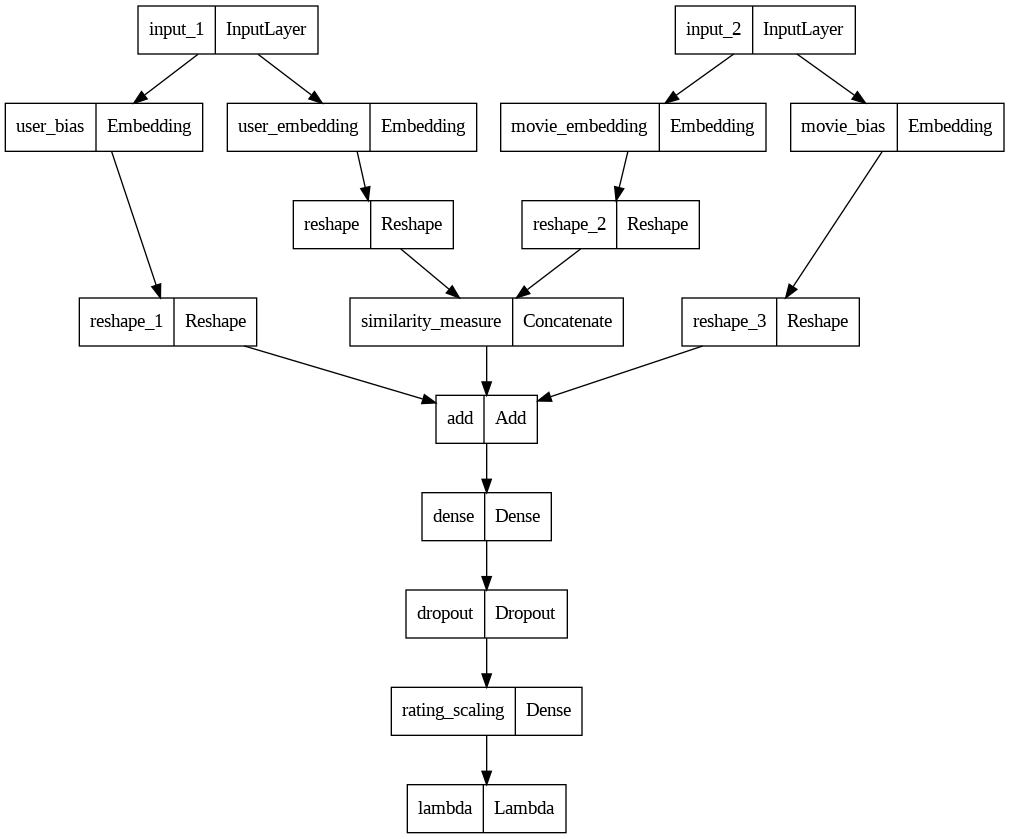

In [45]:
# Number of latent factors
emb_sz = 100

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='user_embedding')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6),name ='user_bias')(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='movie_embedding')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6),name='movie_bias')(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate(name='similarity_measure')([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dropout(0.5)(rating)
rating = layers.Dense(1, activation='sigmoid',name='rating_scaling')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [46]:
history = model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1407/1407 [==============================] - 30s 20ms/step - loss: 0.9675 - root_mean_squared_error: 0.9833 - val_loss: 0.8039 - val_root_mean_squared_error: 0.8960
Epoch 2/5
1407/1407 [==============================] - 15s 11ms/step - loss: 0.8048 - root_mean_squared_error: 0.8963 - val_loss: 0.7866 - val_root_mean_squared_error: 0.8860
Epoch 3/5
1407/1407 [==============================] - 16s 12ms/step - loss: 0.7677 - root_mean_squared_error: 0.8750 - val_loss: 0.7866 - val_root_mean_squared_error: 0.8856
Epoch 4/5
1407/1407 [==============================] - 15s 10ms/step - loss: 0.7501 - root_mean_squared_error: 0.8645 - val_loss: 0.7857 - val_root_mean_squared_error: 0.8847
Epoch 5/5
1407/1407 [==============================] - 15s 11ms/step - loss: 0.7377 - root_mean_squared_error: 0.8570 - val_loss: 0.7886 - val_root_mean_squared_error: 0.8860
